In [28]:
# Import Libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Skytrax Website link
base_url= "https://www.airlinequality.com/airline-reviews/british-airways/"
pages=10
page_size=100

In [3]:
#create Dataframe
df=pd.DataFrame()
reviews=[]
for i in range(1,pages+1):
    rating=[]
    category=[]
    url=f"{base_url}/page/{i}/?pagesize={page_size}" # Dynamic URl
    response=requests.get(url)
    soup=BeautifulSoup(response.content,'lxml')
    for j in soup.find_all("div", {"class": "text_content"}):
        reviews.append(j.get_text())
    for stats in soup.find_all("div", {"class" : "review-stats"}):
        for a in stats.find_all("td",{'class' : 'review-value'}):
            rating.append(a.get_text())
        recomend = rating[-1]
        rating = rating[:-1]
        for b in stats.find_all("td",{"class":"review-rating-stars stars"}):
            c = len(b.find_all("span",{"class":"star fill"}))
            rating.append(c)
        rating.append(recomend)
        for d in stats.find_all('td',{'class' : 'review-rating-header'}):
            category.append(d.get_text())
        df1=pd.DataFrame([rating],columns=category)
        df=df.append(df1,ignore_index=True).reset_index(drop=True)
        rating=[]
        category=[]

In [4]:
df['reviews']=reviews
df.head(5)

,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Ground Service,Wifi & Connectivity,Value For Money,Recommended,reviews
0,Boeing 777,Business,Economy Class,Seattle to Edinburgh via Heathrow,May 2023,2.0,4.0,4.0,4.0,2.0,1.0,2,no,"Not Verified | May 3, flew from Seattle to He..."
1,NaN,Solo Leisure,Economy Class,Athens to Durban via London Heathrow,April 2023,4.0,5.0,3.0,3.0,5.0,NaN,4,no,✅ Trip Verified | I went through three flights...
2,A350,Solo Leisure,Business Class,Vancouver to London Heathrow,May 2023,5.0,5.0,4.0,5.0,4.0,NaN,4,yes,✅ Trip Verified | An excellent flight in Club ...
3,NaN,Family Leisure,Economy Class,Vancouver to Barcelona via London,May 2023,3.0,2.0,2.0,3.0,1.0,3.0,1,no,✅ Trip Verified | The flight schedule was dela...
4,NaN,Family Leisure,Economy Class,Boston to Cairo via London,June 2023,1.0,1.0,1.0,1.0,1.0,1.0,1,no,✅ Trip Verified | The worst experience in all ...


## Data Cleaning

In [5]:
#Removing verified or Not verified from the review 
df['reviews'] = df['reviews'].str.split('|').str[1]

In [6]:
#finding Null Values
df.isnull().sum()

Aircraft                  434
Type Of Traveller           1
Seat Type                   0
Route                       3
Date Flown                  0
Seat Comfort               78
Cabin Staff Service        84
Food & Beverages          204
Inflight Entertainment    451
Ground Service             53
Wifi & Connectivity       732
Value For Money             0
Recommended                 0
reviews                     0
dtype: int64

In [7]:
#Removing unnecessary Columns with highest null values
df = df.drop(['Wifi & Connectivity','Inflight Entertainment','Aircraft'], axis=1)

In [8]:
#find mean for the columns with null values
Seat_comfort_mean=df['Seat Comfort'].mean()
Cabin_mean=df['Cabin Staff Service'].mean()
Food_mean=df['Food & Beverages'].mean()
Ground_mean=df['Ground Service'].mean()

In [9]:
#Replacing Null values with mean values in the columns
df['Seat Comfort'].fillna(value=round(Seat_comfort_mean,0),inplace=True)
df['Cabin Staff Service'].fillna(value=round(Cabin_mean,0),inplace=True)
df['Food & Beverages'].fillna(value=round(Food_mean,0),inplace=True)
df['Ground Service'].fillna(value=round(Ground_mean,0),inplace=True)
df['Type Of Traveller'].fillna(value='Couple Leisure',inplace=True)
df['Route'].fillna(value='San Francisco to London',inplace=True)

In [10]:
#Checkinf for Null Values
df.isnull().sum()

Type Of Traveller      0
Seat Type              0
Route                  0
Date Flown             0
Seat Comfort           0
Cabin Staff Service    0
Food & Beverages       0
Ground Service         0
Value For Money        0
Recommended            0
reviews                0
dtype: int64

In [11]:
#Drop Duplicate Values
df.drop_duplicates().head()

#Creating a uniuque Id for Each row
df=df.reset_index().rename(columns={'index':'Id'})
df.head()

,Id,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Recommended,reviews
0,0,Business,Economy Class,Seattle to Edinburgh via Heathrow,May 2023,2.0,4.0,4.0,2.0,2,no,"May 3, flew from Seattle to Heathrow then to..."
1,1,Solo Leisure,Economy Class,Athens to Durban via London Heathrow,April 2023,4.0,5.0,3.0,5.0,4,no,I went through three flights to reach my dest...
2,2,Solo Leisure,Business Class,Vancouver to London Heathrow,May 2023,5.0,5.0,4.0,4.0,4,yes,An excellent flight in Club World on British ...
3,3,Family Leisure,Economy Class,Vancouver to Barcelona via London,May 2023,3.0,2.0,2.0,1.0,1,no,The flight schedule was delayed for one hour....
4,4,Family Leisure,Economy Class,Boston to Cairo via London,June 2023,1.0,1.0,1.0,1.0,1,no,The worst experience in all my years of trave...


## Sentiment Analysis

In [12]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia=SentimentIntensityAnalyzer()

In [13]:
res={}
for i,row in tqdm(df.iterrows(),total=len(df)):
    text=row['reviews']
    id=row['Id']
    res[id]=sia.polarity_scores(text)
    

  0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
#creating a new Dataframe for sentiment analysis results
df1=pd.DataFrame(res).T
df1=df1.reset_index().rename(columns={'index':'Id'})

In [15]:
#Merge both Dataframes
finaldf=pd.merge(df, df1,how='right')
finaldf.head()

,Id,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Recommended,reviews,neg,neu,pos,compound
0,0,Business,Economy Class,Seattle to Edinburgh via Heathrow,May 2023,2.0,4.0,4.0,2.0,2,no,"May 3, flew from Seattle to Heathrow then to...",0.041,0.924,0.034,-0.2500
1,1,Solo Leisure,Economy Class,Athens to Durban via London Heathrow,April 2023,4.0,5.0,3.0,5.0,4,no,I went through three flights to reach my dest...,0.084,0.856,0.060,-0.7390
2,2,Solo Leisure,Business Class,Vancouver to London Heathrow,May 2023,5.0,5.0,4.0,4.0,4,yes,An excellent flight in Club World on British ...,0.000,0.666,0.334,0.9903
3,3,Family Leisure,Economy Class,Vancouver to Barcelona via London,May 2023,3.0,2.0,2.0,1.0,1,no,The flight schedule was delayed for one hour....,0.083,0.917,0.000,-0.7841
4,4,Family Leisure,Economy Class,Boston to Cairo via London,June 2023,1.0,1.0,1.0,1.0,1,no,The worst experience in all my years of trave...,0.180,0.795,0.025,-0.8957


In [16]:
#classify reviews a Good , Bad , Neutral
threshold=0.25
finaldf['sentiment']=finaldf['compound'].apply(lambda x:'Positive' if x > threshold else ('Negative' if x < -threshold else 'Neutral'))
finaldf.head()

,Id,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Recommended,reviews,neg,neu,pos,compound,sentiment
0,0,Business,Economy Class,Seattle to Edinburgh via Heathrow,May 2023,2.0,4.0,4.0,2.0,2,no,"May 3, flew from Seattle to Heathrow then to...",0.041,0.924,0.034,-0.2500,Neutral
1,1,Solo Leisure,Economy Class,Athens to Durban via London Heathrow,April 2023,4.0,5.0,3.0,5.0,4,no,I went through three flights to reach my dest...,0.084,0.856,0.060,-0.7390,Negative
2,2,Solo Leisure,Business Class,Vancouver to London Heathrow,May 2023,5.0,5.0,4.0,4.0,4,yes,An excellent flight in Club World on British ...,0.000,0.666,0.334,0.9903,Positive
3,3,Family Leisure,Economy Class,Vancouver to Barcelona via London,May 2023,3.0,2.0,2.0,1.0,1,no,The flight schedule was delayed for one hour....,0.083,0.917,0.000,-0.7841,Negative
4,4,Family Leisure,Economy Class,Boston to Cairo via London,June 2023,1.0,1.0,1.0,1.0,1,no,The worst experience in all my years of trave...,0.180,0.795,0.025,-0.8957,Negative


## Data Analysis

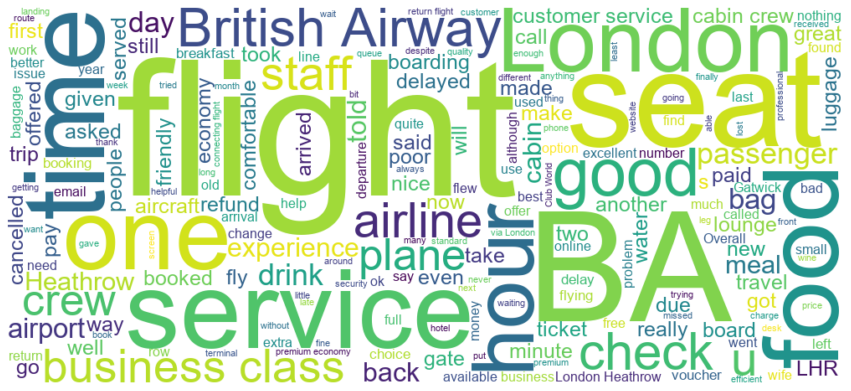

In [17]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
review_word = []

for i in df['reviews']:
    a = i.split(' ')
    for x in a:
        review_word.append(x)

unique_string = " ".join(review_word)
font_path = './arial.ttf'
wc = WordCloud(font_path=font_path,width=1000, height=450, background_color='white').generate(unique_string)

plt.figure(figsize=(15, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

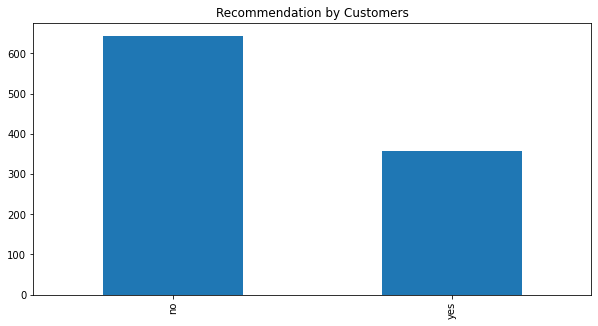

In [18]:
#Displaying Frequency of Recommendations by Customers 
ax=finaldf['Recommended'].value_counts().sort_index()\
    .plot(kind='bar',
          title='Recommendation by Customers',
          figsize=(10,5))

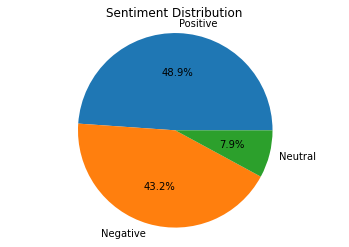

In [19]:
#Distribution of Reviews 
Sentiment_percentage=finaldf.sentiment.value_counts()/finaldf.sentiment.value_counts().sum()*100
plt.pie(Sentiment_percentage, labels=Sentiment_percentage.index, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Sentiment Distribution')
plt.show()

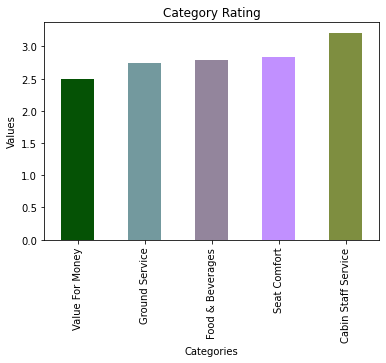

In [49]:
Average_rating=finaldf.iloc[:,5:10].mean()
ax = Average_rating.sort_values().plot(kind='bar',color=random_colors)
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Category Rating')
plt.show()

## Text Analysis

In [20]:
import nltk
# Tokenize the text into individual words
finaldf['reviews'] = finaldf['reviews'].apply(nltk.word_tokenize)

In [21]:
from nltk.corpus import stopwords
# Remove stopwords
stopwords = set(stopwords.words('english'))
finaldf['reviews'] = finaldf['reviews'].apply(lambda x: [word for word in x if word not in stopwords])
finaldf.head()

,Id,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Recommended,reviews,neg,neu,pos,compound,sentiment
0,0,Business,Economy Class,Seattle to Edinburgh via Heathrow,May 2023,2.0,4.0,4.0,2.0,2,no,"[May, 3, ,, flew, Seattle, Heathrow, Edinburgh...",0.041,0.924,0.034,-0.2500,Neutral
1,1,Solo Leisure,Economy Class,Athens to Durban via London Heathrow,April 2023,4.0,5.0,3.0,5.0,4,no,"[I, went, three, flights, reach, destination, ...",0.084,0.856,0.060,-0.7390,Negative
2,2,Solo Leisure,Business Class,Vancouver to London Heathrow,May 2023,5.0,5.0,4.0,4.0,4,yes,"[An, excellent, flight, Club, World, British, ...",0.000,0.666,0.334,0.9903,Positive
3,3,Family Leisure,Economy Class,Vancouver to Barcelona via London,May 2023,3.0,2.0,2.0,1.0,1,no,"[The, flight, schedule, delayed, one, hour, .,...",0.083,0.917,0.000,-0.7841,Negative
4,4,Family Leisure,Economy Class,Boston to Cairo via London,June 2023,1.0,1.0,1.0,1.0,1,no,"[The, worst, experience, years, travel, ., My,...",0.180,0.795,0.025,-0.8957,Negative


In [22]:
#Creating a list of words from the review column
words=[]
for i,row in finaldf.iterrows():
    for j in row['reviews']:
        words.append(j)

In [23]:
#creating a Dataframe
df3=pd.DataFrame()

#Storing the List of words in DataFrame
df3['words']=words

In [24]:
#Filtering column that contains only Alphabets
df3['words'] = df3[df3['words'].str.contains(r'\b[A-Za-z]+\b', regex=True)]

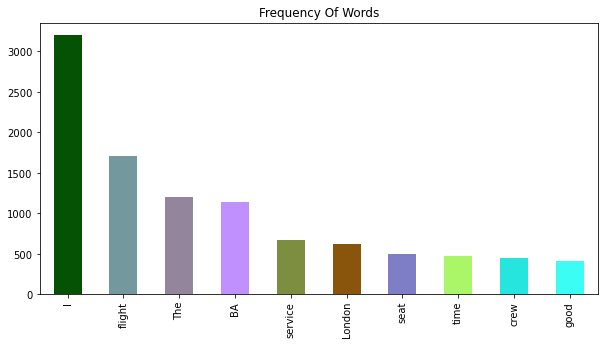

In [29]:
# Generate random colors
random_colors = np.random.rand(10, 3)  # Generate an array of random RGB values

#Frequency of Words
ax=df3.words.value_counts().nlargest(10)\
    .plot(kind='bar',
      title="Frequency Of Words",
      figsize=(10,5),
         color=random_colors)